In [1]:
import torch
from transformers import MT5ForConditionalGeneration, MT5Config, MT5EncoderModel, MT5Tokenizer, Trainer, TrainingArguments
from progeny_tokenizer import TAPETokenizer
import numpy as np
import math
import random
import scipy
import time
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, Dataset, BatchSampler
import typing
from pathlib import Path
import argparse
from collections import OrderedDict
import pickle

import matplotlib.pyplot as plt

# Analyze generated sequences

In [2]:
tsv_name = 'generated_seqs/baseline_gen/rerunwlatentheadpred_tophalf_12ep_250K-basegen_seqs260000.tsv'

In [3]:
df = pd.read_table(tsv_name)

In [4]:
df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq
0,0.468239,-1.780831,SSYEEQIKTFIDKFKHVAEMLFHQSEQGMMFYMMNYLMMQFMLFMK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
1,0.577867,-4.800953,STKEMVAKTFLDMFNHEFFIVFLYSFMMAEMLFLFIKFQSTLAQYY...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2,0.609596,0.808763,SSIEGQAKMFLDKHEHEYEDLFENFFTKMMLFMFMMFMNYNMKAFQ...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
3,0.714211,0.079907,STIETVAKSFLDKFNVEAETGFGQFMMQMYAMMMMQLFELMLQLMK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
4,0.787052,-2.055216,KTIEEAAGTMLDKLKAFAKNMLMMMKYEMQAFFMFFNNILKNFLMM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...,...,...
260649,34.154423,3.179507,HTGVLQAKTFLDKFAHMSYDLFTLNIMEEFEQAFLKFHMAANAALQ...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260650,34.228806,5.039864,NTIEIQFKTHLDKFTHEAEDLFYQSSLASMNYNTNITEENVQAMNF...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260651,34.324348,4.344697,STIEEQYKTFLDKENHEVEDLFYQRSLASMNMNTNITEENAQNMAN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260652,34.395195,3.548505,STIETQAKTMLDLFNHEFFDEFYQSALGSMNKNTIIFEQFFSFLQK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


## filter out sequences without constant region

In [5]:
wt_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
constant_region = 'NTNITEEN'
wt_cs_ind = wt_seq.index(constant_region)

In [6]:
indices_to_drop = []
dropped_seqs = []
for index, row in df.iterrows():
    seq = row['MT_seq']
    if constant_region not in seq:
        indices_to_drop.append(index)
        dropped_seqs.append(seq)
    else:
        cs_ind = seq.index(constant_region)
        if cs_ind != wt_cs_ind:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)

In [7]:
df = df.drop(indices_to_drop)
print(len(df))

257333


## filter out sequences with invalid token

In [8]:
rejected_tokens = ["<pad>", "<sep>", "<cls>", "<mask>", "<unk>"]

In [9]:
indices_to_drop = []
dropped_seqs = []
for index, row in df.iterrows():
    seq = row['MT_seq']
    
    for rejected_token in rejected_tokens:
        if rejected_token in seq:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)
            break
            

In [10]:
df = df.drop(indices_to_drop)
print(len(df))

257145


In [11]:
df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq
28,2.789537,-10.144451,SDIEEQAKTFLDKFNHEAEDLFYQSSLRSMVYNTNITEENIQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
29,2.796858,-11.077489,SSIEEQAKTFLDKFNHEAEDYFYQSSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
30,2.805789,-11.647189,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
31,2.808174,-12.024853,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
32,2.808599,-10.844015,SDIEEQAKTFLDKFLHEAEDLFYQSSLASFNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...,...,...
260646,33.955925,4.574232,STIEEQFKTFLDTFNHEAEDLEPQYSLANMNYNTNITEENPMNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260647,33.976833,5.299477,DTIEEFFKTFLDKFNHNAEDKFYQSSLASRNYNTNITEENVQSMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260650,34.228806,5.039864,NTIEIQFKTHLDKFTHEAEDLFYQSSLASMNYNTNITEENVQAMNF...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260651,34.324348,4.344697,STIEEQYKTFLDKENHEVEDLFYQRSLASMNMNTNITEENAQNMAN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


## Analyze hamming distance

In [12]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0
 
    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [13]:
hamming_dist_list = []

In [14]:
wt_seq = df.iloc[0]['WT_seq']

In [15]:
wt_seq

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'

In [16]:
for index, row in df.iterrows():
    gen_seq = row['MT_seq']
    h_dist = hamming_dist(gen_seq, wt_seq)
    hamming_dist_list.append(h_dist)

In [17]:
hamming_dist_list

[10,
 8,
 7,
 7,
 9,
 11,
 7,
 6,
 8,
 17,
 11,
 8,
 7,
 9,
 10,
 11,
 6,
 11,
 9,
 9,
 8,
 6,
 10,
 12,
 7,
 10,
 10,
 10,
 8,
 8,
 5,
 12,
 9,
 10,
 8,
 8,
 11,
 6,
 7,
 6,
 7,
 9,
 9,
 10,
 11,
 9,
 7,
 9,
 8,
 5,
 8,
 5,
 8,
 10,
 9,
 8,
 12,
 5,
 11,
 10,
 8,
 8,
 8,
 11,
 9,
 10,
 5,
 9,
 6,
 6,
 8,
 7,
 6,
 15,
 11,
 7,
 9,
 11,
 19,
 12,
 11,
 12,
 10,
 10,
 7,
 9,
 11,
 9,
 8,
 13,
 8,
 10,
 8,
 7,
 10,
 7,
 8,
 4,
 12,
 8,
 8,
 15,
 11,
 7,
 10,
 8,
 8,
 10,
 9,
 5,
 12,
 16,
 6,
 9,
 9,
 10,
 15,
 19,
 9,
 8,
 10,
 10,
 8,
 8,
 9,
 9,
 6,
 17,
 13,
 8,
 13,
 9,
 9,
 9,
 6,
 17,
 4,
 10,
 5,
 13,
 9,
 9,
 6,
 10,
 7,
 14,
 8,
 8,
 15,
 9,
 7,
 10,
 8,
 9,
 5,
 9,
 12,
 9,
 12,
 10,
 11,
 10,
 7,
 11,
 17,
 13,
 9,
 9,
 9,
 12,
 15,
 7,
 13,
 6,
 9,
 12,
 14,
 12,
 8,
 15,
 14,
 12,
 9,
 12,
 7,
 5,
 6,
 5,
 11,
 11,
 11,
 13,
 11,
 9,
 11,
 12,
 10,
 17,
 9,
 6,
 10,
 6,
 11,
 6,
 10,
 9,
 15,
 6,
 6,
 12,
 8,
 14,
 17,
 9,
 10,
 12,
 7,
 17,
 9,
 4,
 9,
 11,
 13,
 14,
 6,
 1

In [18]:
print("Hamming distance stats")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))

Hamming distance stats
max:  51
min:  2
median:  11.0
mean:  11.146749888195377


Text(0.5, 1.0, 'Hamming Distance from WT seq')

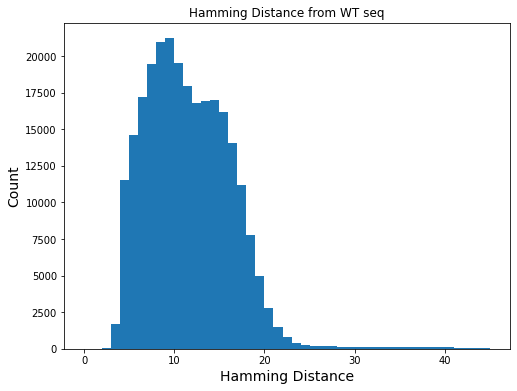

In [19]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, label='generated', bins=[i for i in range(46)])
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Count", size=14)
plt.title("Hamming Distance from WT seq")
# plt.legend(loc='upper left')

hamming distance for generator training data

In [20]:
gen_train_data = 'data/gen_train_data/top_half_ddG/train_ddG.pkl'

In [21]:
gen_train_df = pd.read_pickle(gen_train_data)

In [22]:
wt_seq = gen_train_df.iloc[0]['WT_seq']

In [23]:
wt_seq

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'

In [24]:
gen_train_hamming_dist_list = []
for index, row in gen_train_df.iterrows():
    train_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, wt_seq)
    gen_train_hamming_dist_list.append(h_dist)

Text(0.5, 1.0, 'Hamming Distance from WT seq')

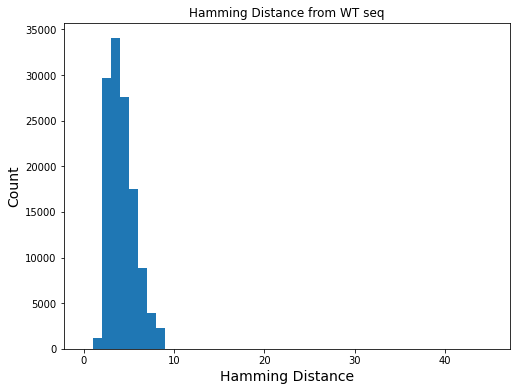

In [25]:
plt.figure(figsize=(8,6))
plt.hist(gen_train_hamming_dist_list, label='train_data', bins=[i for i in range(46)])
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Count", size=14)
plt.title("Hamming Distance from WT seq")
# plt.legend(loc='upper left')

In [26]:
len(hamming_dist_list)

257145

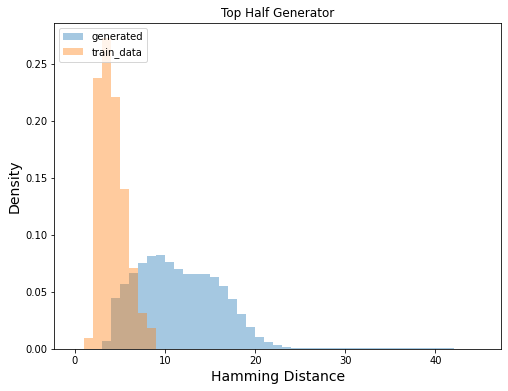

In [27]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(46)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Top Half Generator")
plt.legend(loc='upper left')

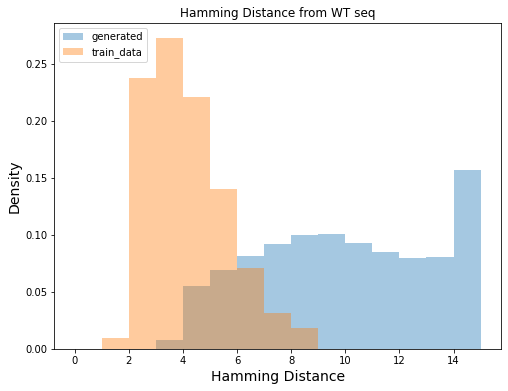

In [28]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(16)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(16)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Hamming Distance from WT seq")
plt.legend(loc='upper left')

# Analyze ddG values of gen 10K

In [29]:
from tape.metrics import spearmanr

In [30]:
results_tsv_name = "foldx_sim_results/tophalf-basegen_top10Klatentheadfiltered/results_full.tsv"
# Emin_results_tsv_name = "foldx_sim_results/tophalf-basegen_seqsforEmin_foldx_results/results_full.tsv"

In [31]:
ddG_df = pd.read_table(results_tsv_name)

In [32]:
ddG_df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
0,6.204562,-6.198444,STIEEQAKTFIDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.943782
1,6.566597,-6.198411,VTIEEQAKTFLDSFIHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.763596
2,3.709481,-6.197896,SGIEEFAKRFLDKFNHNAEDLFYFMILAKMNYNTNITEENVINMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.828940
3,5.815841,-6.197204,SSIEEQAKTFLDKFNHEAMDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.616186
4,6.044264,-6.196896,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNYNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.670446
...,...,...,...,...,...,...,...,...
9995,3.506202,-9.032804,STIEEQAKAFLDKFNHEAEDLFYQMSLASMNYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-3.044100
9996,3.213400,-9.030958,STIEEQAKTFLDKFNHEAEDLFYQSMLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-2.146290
9997,3.841218,-9.030471,STHEEMAKQFLDKFNHEAEDLFYQMSLAKRNYNTNITEENIQNMMN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-6.530910
9998,3.684652,-9.029869,SDIEEQAKTFLEKFNHEAEDLFYQSSLASMYYNTNITEENVQNLNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.944460


In [33]:
disc_pred_list = ddG_df['latent_head_pred']
# disc_pred_list = ddG_df['disc_pred']
ddG_list = ddG_df['ddG']

In [34]:
disc_ddG_cor = spearmanr(disc_pred_list, ddG_list)

In [35]:
disc_ddG_cor

0.5535249780065552

In [36]:
# Disc-predicted most stable ones first
ddG_df = ddG_df.sort_values(by='latent_head_pred', ascending=True)
ddG_list = ddG_df['ddG']
# ddG_df = ddG_df.sort_values(by='disc_pred', ascending=True)

In [37]:
ddG_df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.834782,-12.848934,GDIEEQAKTFLDSFNHEAENLFMQSSLASMNYNTNITEENVQNMNG...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.716760
5751,2.855145,-12.228134,SDIEEQAKTFLDKFNYEAEDLFLQSSLASMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.955920
5752,2.888042,-12.105712,STIEEQAKTFLDKFNHEAEKLFYQFSLASMNYNTNITEENQQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.728830
5753,2.870499,-12.081381,KTIEEFAKTFLMKFNHEAEMLFYQSSLLSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.589710
5754,2.808174,-12.024853,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.706710
...,...,...,...,...,...,...,...,...
5745,7.200650,-5.630886,STIEEIAKTFLDKFNHEAEDLFYQSSLLSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.644684
5746,7.376093,-5.630832,STIEEQAKTFLDKFNHEAEDLFYQMRLASMNYNTNITEENVQNMLN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.793518
5747,6.886302,-5.630334,ATTEEQAKTFLEMFNHEAEVLFYQSSLASMNYNTNITEENSQNMIN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-2.781120
5748,7.971996,-5.630300,STIEEQAVTFLDKFNHEAEDLFYQSSLASMMYNTNITEENDQNMAN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.400420


In [38]:
top_half_stable_df = ddG_df[:len(ddG_df)//2]

In [39]:
top_half_stable_df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.834782,-12.848934,GDIEEQAKTFLDSFNHEAENLFMQSSLASMNYNTNITEENVQNMNG...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.716760
5751,2.855145,-12.228134,SDIEEQAKTFLDKFNYEAEDLFLQSSLASMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.955920
5752,2.888042,-12.105712,STIEEQAKTFLDKFNHEAEKLFYQFSLASMNYNTNITEENQQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.728830
5753,2.870499,-12.081381,KTIEEFAKTFLMKFNHEAEMLFYQSSLLSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.589710
5754,2.808174,-12.024853,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.706710
...,...,...,...,...,...,...,...,...
5495,5.400882,-6.948266,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.261380
5496,7.626733,-6.948233,STIEEQAKTFLRKFSHLAEDLFYQSSLASMNYNTNITEENVQNMGN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-2.149740
5497,4.853433,-6.948159,HTIEEQAKTFLDKFNHEAEDLFYMYSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.128640
5498,5.197186,-6.947451,STIEEQAKTFLDKFNHFAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.206940


In [40]:
gen_train_ddG_list = gen_train_df['ddG']

In [41]:
len(ddG_list)

10000

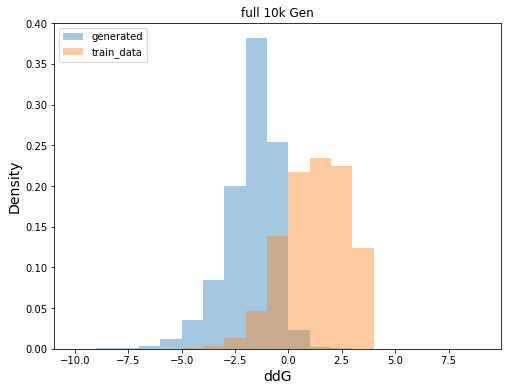

In [42]:
plt.figure(figsize=(8,6))
plt.hist(ddG_list, density=True, label='generated', bins=[i for i in range(-10, 10)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

In [43]:
len(top_half_stable_df['ddG'])

5000

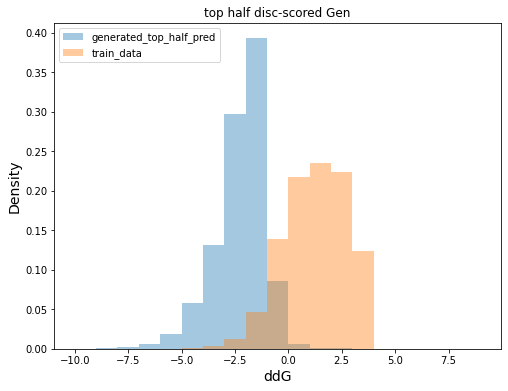

In [44]:
plt.figure(figsize=(8,6))
plt.hist(top_half_stable_df['ddG'], density=True, label='generated_top_half_pred', bins=[i for i in range(-10, 10)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("top half disc-scored Gen")
plt.legend(loc='upper left')

In [45]:
np.max(top_half_stable_df['ddG'])

9.57676

In [46]:
np.min(top_half_stable_df['ddG'])

-9.12763

In [47]:
np.mean(top_half_stable_df['ddG'])

-2.2499733461999996

In [48]:
np.median(top_half_stable_df['ddG'])

-2.031325

In [49]:
np.max(gen_train_ddG_list)

3.5751

In [50]:
np.min(gen_train_ddG_list)

-6.59818

In [51]:
np.mean(gen_train_ddG_list)

1.26221709496

In [52]:
np.median(gen_train_ddG_list)

1.3439199999999998

## plot top 100, 1k and 10k distribution

topk:  10000
topk_disc_ddG_cor:  -0.06937043126142899
topk:  1000
topk_disc_ddG_cor:  -0.05356330172399163
topk:  100
topk_disc_ddG_cor:  -0.15233123312331232


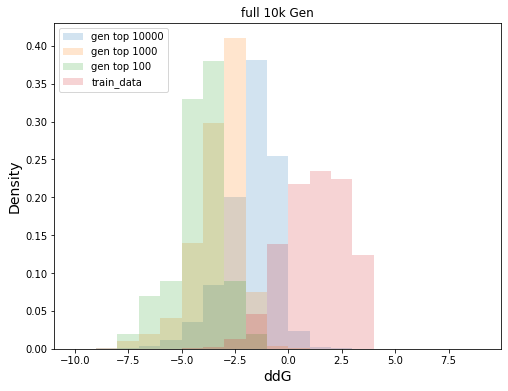

In [53]:
topk_hist_list = [10000, 1000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)



plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

topk:  10000
topk_disc_ddG_cor:  -0.06937043126142899
topk:  100
topk_disc_ddG_cor:  -0.15233123312331232


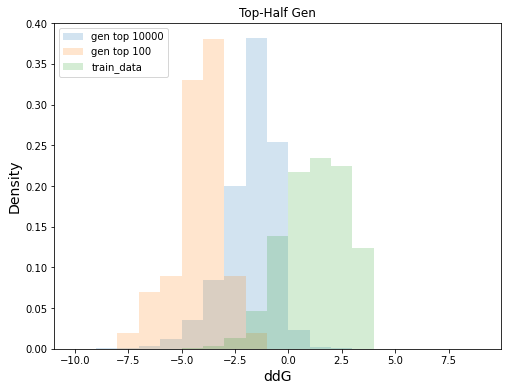

In [54]:
topk_hist_list = [10000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)


plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("Top-Half Gen")
plt.legend(loc='upper left')

top 10, 100, 1000 by disc ranking

In [55]:
ddG_df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.834782,-12.848934,GDIEEQAKTFLDSFNHEAENLFMQSSLASMNYNTNITEENVQNMNG...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.716760
5751,2.855145,-12.228134,SDIEEQAKTFLDKFNYEAEDLFLQSSLASMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.955920
5752,2.888042,-12.105712,STIEEQAKTFLDKFNHEAEKLFYQFSLASMNYNTNITEENQQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.728830
5753,2.870499,-12.081381,KTIEEFAKTFLMKFNHEAEMLFYQSSLLSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.589710
5754,2.808174,-12.024853,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.706710
...,...,...,...,...,...,...,...,...
5745,7.200650,-5.630886,STIEEIAKTFLDKFNHEAEDLFYQSSLLSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.644684
5746,7.376093,-5.630832,STIEEQAKTFLDKFNHEAEDLFYQMRLASMNYNTNITEENVQNMLN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.793518
5747,6.886302,-5.630334,ATTEEQAKTFLEMFNHEAEVLFYQSSLASMNYNTNITEENSQNMIN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-2.781120
5748,7.971996,-5.630300,STIEEQAVTFLDKFNHEAEDLFYQSSLASMMYNTNITEENDQNMAN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.400420


In [56]:
topK_list = [10, 100, 1000, 10000]

In [57]:
topK_df = ddG_df[:10]
topK_df

,disc_pred,latent_head_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.834782,-12.848934,GDIEEQAKTFLDSFNHEAENLFMQSSLASMNYNTNITEENVQNMNG...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.71676
5751,2.855145,-12.228134,SDIEEQAKTFLDKFNYEAEDLFLQSSLASMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.95592
5752,2.888042,-12.105712,STIEEQAKTFLDKFNHEAEKLFYQFSLASMNYNTNITEENQQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.72883
5753,2.870499,-12.081381,KTIEEFAKTFLMKFNHEAEMLFYQSSLLSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.58971
5754,2.808174,-12.024853,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.70671
5755,2.918966,-11.967164,NNIEEQAKTFLDKFNSEAEQLFYQASLAAMNYNTNITEENVQRMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-6.69701
5756,2.976009,-11.850731,STYEEQAMTFLKKFNREAFDLFYQSSLMLMNYNTNITEENLQNMFR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-6.70226
5757,2.851628,-11.814441,SDIEEQAKTFLEKFNHEAEDLFYQSSLAMMNYNTNITEENVYNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-3.75789
5758,2.883835,-11.788263,MTIEEQAKTFLDKFNHEAEDLFYQSSLALMNYNTNITEENVQNMYN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-5.69156
5759,2.816030,-11.774632,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMFFNTNITEENVQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.94509


In [58]:
train_75pct =  np.percentile(gen_train_ddG_list, 25)

In [59]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    
    PCI_75pct = np.sum(topK_df['ddG'] < train_75pct) / len(topK_df['ddG'])
    print("PCI_75pct: ", PCI_75pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


PCI_75pct = np.sum(gen_train_ddG_list < train_75pct) / len(gen_train_ddG_list)
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -3.75789
min:  -6.70226
mean:  -5.349174
median:  -5.272815
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  -1.60895
min:  -7.70877
mean:  -4.249195800000001
median:  -4.0276
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1000
max:  0.262243
min:  -8.52999
mean:  -3.261414242
median:  -3.0212849999999998
PCI_75pct:  0.999
PCI_WT:  0.999
____________________
top K:  10000
max:  25.9089
min:  -9.12763
mean:  -1.7343698282000002
median:  -1.5258099999999999
PCI_75pct:  0.9854
PCI_WT:  0.9726
____________________
top half:  5000
max:  9.57676
min:  -9.12763
mean:  -2.2499733461999996
median:  -2.031325
PCI_75pct:  0.995
PCI_WT:  0.992
____________________
train dataset:  125000
max:  3.5751
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
PCI_75pct:  0.25
PCI_WT:  0.200864
____________________


In [60]:
topK_list = [10, 100, 1000, 10000]
percentile_list = [100, 95, 90, 85, 80, 75]

In [61]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -3.75789
min:  -6.70226
mean:  -5.349174
median:  -5.272815
PCI_100pct:  0.2
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  -1.60895
min:  -7.70877
mean:  -4.249195800000001
median:  -4.0276
PCI_100pct:  0.07
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1000
max:  0.262243
min:  -8.52999
mean:  -3.261414242
median:  -3.0212849999999998
PCI_100pct:  0.021
PCI_95pct:  0.991
PCI_90pct:  0.998
PCI_85pct:  0.999
PCI_80pct:  0.999
PCI_75pct:  0.999
PCI_WT:  0.999
____________________
top K:  10000
max:  25.9089
min:  -9.12763
mean:  -1.7343698282000002
median:  -1.5258099999999999
PCI_100pct:  0.0036
PCI_95pct:  0.6421
PCI_90pct:  0.8635
PCI_85pct:  0.9443
PCI_80pct:  0.9723
PCI_75pct:  0.9854
PCI_WT:  0.9726
____________________
top half:  5000
max:  9.57676
min:  -9.12763
mean:  -2.2499733461999996
median:  -2.031

In [62]:
topK_list = [10, 100, 1000, 10000]
percentile_list = [100]

for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    print("max: ", np.max(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))
print("max: ", np.max(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
min:  -6.70226
mean:  -5.349174
median:  -5.272815
max:  -3.75789
PCI_100pct:  0.2
PCI_WT:  1.0
____________________
top K:  100
min:  -7.70877
mean:  -4.249195800000001
median:  -4.0276
max:  -1.60895
PCI_100pct:  0.07
PCI_WT:  1.0
____________________
top K:  1000
min:  -8.52999
mean:  -3.261414242
median:  -3.0212849999999998
max:  0.262243
PCI_100pct:  0.021
PCI_WT:  0.999
____________________
top K:  10000
min:  -9.12763
mean:  -1.7343698282000002
median:  -1.5258099999999999
max:  25.9089
PCI_100pct:  0.0036
PCI_WT:  0.9726
____________________
top half:  5000
min:  -9.12763
mean:  -2.2499733461999996
median:  -2.031325
max:  9.57676
PCI_100pct:  0.006
PCI_WT:  0.992
____________________
train dataset:  125000
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
max:  3.5751
PCI_100pct:  0.0
PCI_WT:  0.200864
____________________
